In [18]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

# display image
def display_image(image, title='Image'):
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def binarize_image(image):
	_, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
	return binarized


def crop_to_bounding_box(image, padding=10):
    # Invert the grayscale image to make black pixels white (255)
    inverted_gray = cv2.bitwise_not(image)

    # Apply a binary threshold to the inverted grayscale image
    _, binary = cv2.threshold(inverted_gray, 1, 255, cv2.THRESH_BINARY)

    # Find coordinates of all non-zero pixels
    coords = np.column_stack(np.where(binary > 0))

    # Get the bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Crop the bounding box from the original image
    cropped_image = image[x_min:x_max, y_min:y_max]
    # cropped_image = image[x_min - padding:x_max + padding, y_min - padding:y_max + padding]

    # pad image
    padded_image = cv2.copyMakeBorder(cropped_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=255)

    return padded_image


# count disconnected components
def disconnected_components(image):
	# Invert the image to make black pixels white (255)
	inverted = cv2.bitwise_not(image)

	# Find connected components
	num_labels, labels = cv2.connectedComponents(inverted)

	# show connected components
	image_with_components = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
	from matplotlib.cm import Set1 as color_map
	for label in range(1, num_labels):
		image_with_components[labels == label] = np.array(color_map(label)[:3]) * 255
	# display_image(image_with_components, title='Disconnected Components')

	return num_labels - 1

def perimetric_complexity(image):
    # Invert the image to make black pixels white (255)
    image = cv2.bitwise_not(image)

    # Find the contours of the character (foreground)
    contours, _ = cv2.findContours(image, cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # print(f'Number of contours: {len(contours)}')

    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) * 0

    # Highlight the skeleton with different colors
    from matplotlib.cm import Set1 as color_map
    for i, contour in enumerate(contours):
        color = np.array(color_map(i)[:3]) * 255
        cv2.drawContours(image_with_contours, [contour], -1, color, 3)

    # display_image(image_with_contours, title='Contours')

    # Calculate the perimeter (P) of the character
    perimeter = 0
    for contour in contours:
        perimeter += cv2.arcLength(contour, True)

    # Calculate the area (A) of the character
    # area = 0
    # for contour in contours:
    #     area += cv2.contourArea(contour)

    area = np.sum(image == 255)

    # print(f'Area: {area:.2f} sq. px')
    # print(f'Perimeter: {perimeter:.2f} px')

    # Calculate the Perimetric Complexity (PC)
    if area != 0:
        perimetric_complexity = (perimeter**2) / (area * 4 * np.pi)
    else:
        perimetric_complexity = float('inf')

    return perimetric_complexity


In [19]:
import pandas as pd
from tqdm import tqdm

In [20]:
TELUGU_FONT = './fonts/NotoSansTelugu-Regular.ttf'
# TELUGU_FONT = './fonts/NATS.ttf'
ENGLISH_FONT = './fonts/NotoSans-Regular.ttf'

In [21]:
def generate_image(string):
	font = ImageFont.truetype(TELUGU_FONT, 250)
	# font = ImageFont.truetype(ENGLISH_FONT, 250)
	
	image = Image.new('RGB', (500, 500), 'white')
	draw = ImageDraw.Draw(image)
	draw.text((0, 0), string, (0, 0, 0), font=font)
	# image.save(os.path.join(folder, f'image_{string}.png'))
	# plt.axis('off')
	# plt.imshow(image)
	# plt.show()

	return image

In [22]:
import concurrent.futures

In [23]:
TELUGU_CONSONANTS = [
    'క', 'ఖ', 'గ', 'ఘ', 'ఙ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
    'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ల', 'వ', 'శ',
    'ష', 'స', 'హ', 'ళ', 'ఱ'
]
TELUGU_VOWELS = [
    'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ'
]
TELUGU_VOWEL_SIGNS = [
    '', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ'
]

vowels = TELUGU_VOWELS + ['అం', 'అః']
consonants = TELUGU_CONSONANTS + ['క్ష']
wordlist = vowels + consonants

In [24]:

# def process_word(word):
#     """Process a single word to get graphical complexities."""
#     image = generate_image(word)
#     image = np.array(image)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = binarize_image(image)
#     image = crop_to_bounding_box(image)
#     pc = perimetric_complexity(image)
#     dc = disconnected_components(image)
#     return (word, dc, pc)

# words_measures = []

# # Using ThreadPoolExecutor to process words in parallel
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(process_word, word) for word in wordlist]
#     for future in tqdm(concurrent.futures.as_completed(futures), total=len(wordlist)):
#         words_measures.append(future.result())

# # Create DataFrame and save results
# df = pd.DataFrame(words_measures, columns=['akshara', 'dc', 'pc'])
# # df.to_csv('words_measures.csv', index=False)

# # sort
# df = df.sort_values(by='akshara')
# df

In [25]:
df = pd.read_csv('basic_aksharas_gc.csv')
df.head()

,akshara,dc,pc,sf,cp
0,అ,1,12.089158,3,2
1,ఆ,1,10.435550,4,2
2,ఇ,1,10.133217,4,2
3,ఈ,1,15.638364,5,4
4,ఉ,1,11.137752,5,5


In [26]:
import matplotlib.font_manager as fm
telugu_prop = fm.FontProperties(fname=TELUGU_FONT)
english_prop = fm.FontProperties(fname=ENGLISH_FONT)
# global font
plt.rcParams['font.family'] = [english_prop.get_name(), telugu_prop.get_name()]

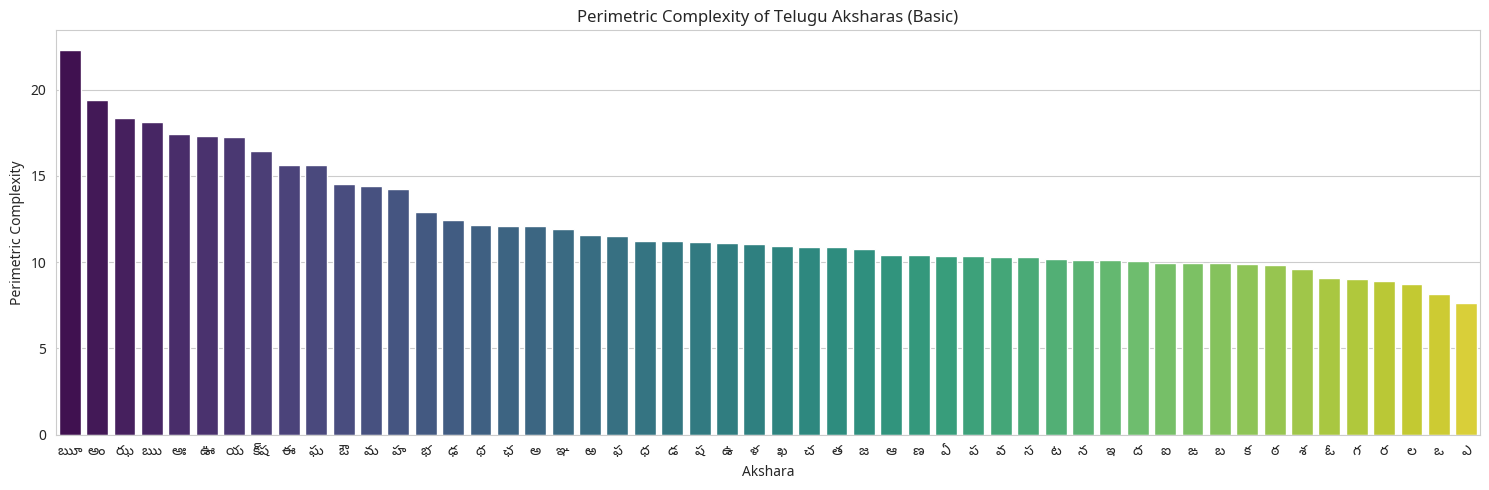

In [27]:
import seaborn as sns

# Plot the Perimetric Complexity (PC) of each character
plt.figure(figsize=(15, 5))
sns.barplot(x='akshara', y='pc', data=df.sort_values(by='pc', ascending=False), palette='viridis', hue='akshara')
plt.xlabel('Akshara')
plt.ylabel('Perimetric Complexity')
plt.title('Perimetric Complexity of Telugu Aksharas (Basic)')
plt.tight_layout()
plt.show()

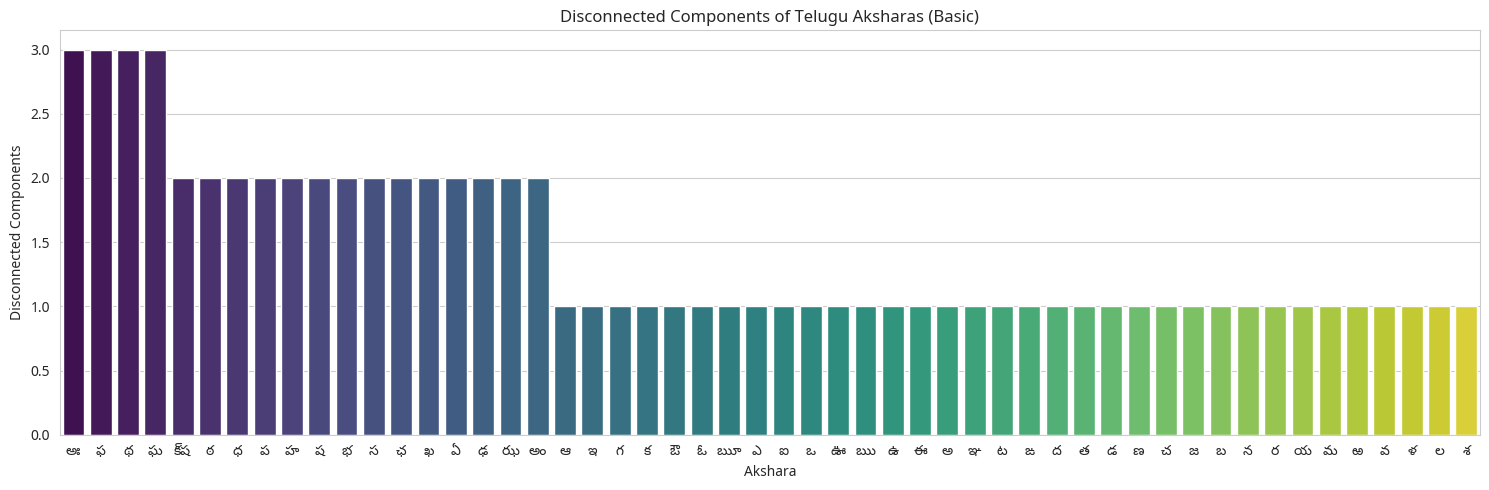

In [28]:
# Plot the Disconnected Components (DC) of each character
plt.figure(figsize=(15, 5))
sns.barplot(x='akshara', y='dc', data=df.sort_values(by='dc', ascending=False), palette='viridis', hue='akshara')
plt.xlabel('Akshara')
plt.ylabel('Disconnected Components')
plt.title('Disconnected Components of Telugu Aksharas (Basic)')
plt.tight_layout()

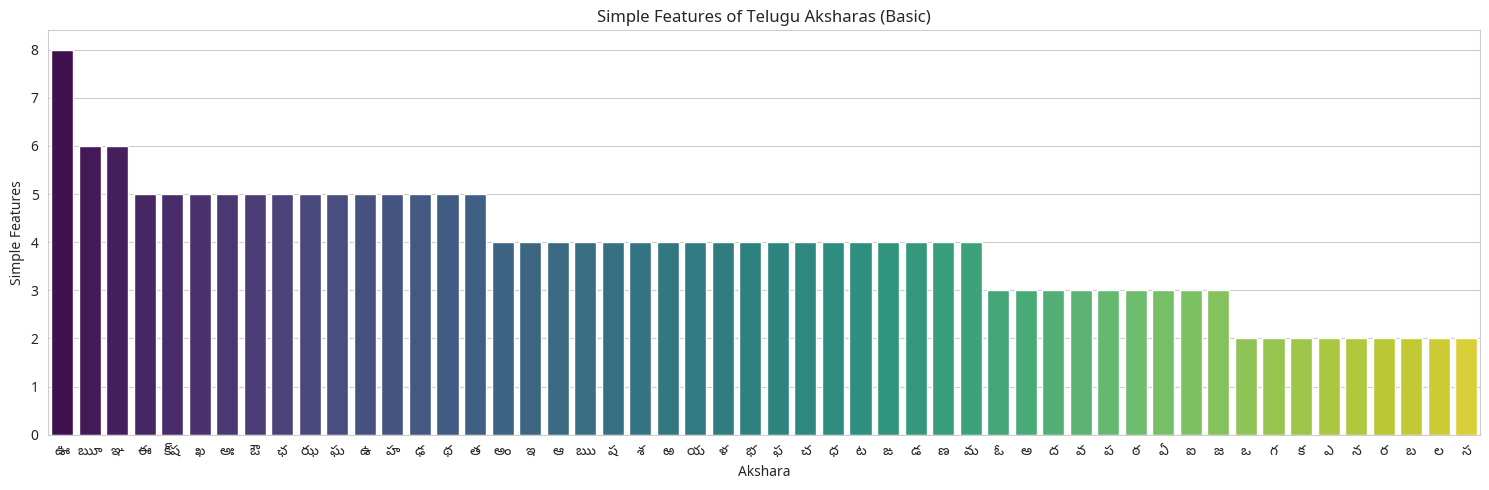

In [29]:
# Plot the Simple Features (SF) of each character
plt.figure(figsize=(15, 5))
sns.barplot(x='akshara', y='sf', data=df.sort_values(by='sf', ascending=False), palette='viridis', hue='akshara')
plt.xlabel('Akshara')
plt.ylabel('Simple Features')
plt.title('Simple Features of Telugu Aksharas (Basic)')
plt.tight_layout()
plt.show()

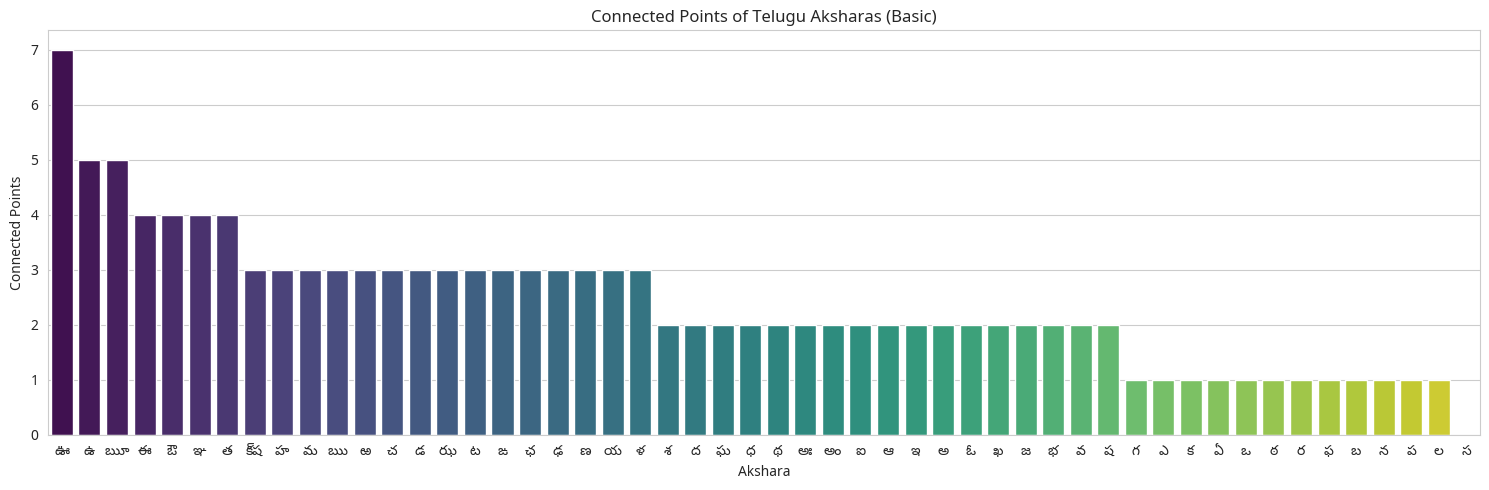

In [30]:
# Plot the Connected Points (CP) of each character
plt.figure(figsize=(15, 5))
sns.barplot(x='akshara', y='cp', data=df.sort_values(by='cp', ascending=False), palette='viridis', hue='akshara')
plt.xlabel('Akshara')
plt.ylabel('Connected Points')
plt.title('Connected Points of Telugu Aksharas (Basic)')
plt.tight_layout()
plt.show()

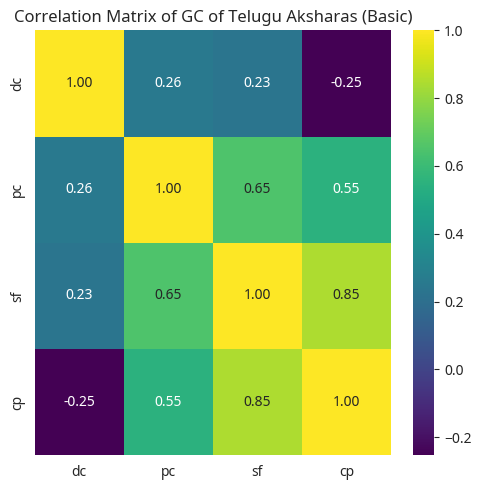

In [31]:
# Correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(df[['dc', 'pc', 'sf', 'cp']].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of GC of Telugu Aksharas (Basic)')
plt.tight_layout()
plt.show()

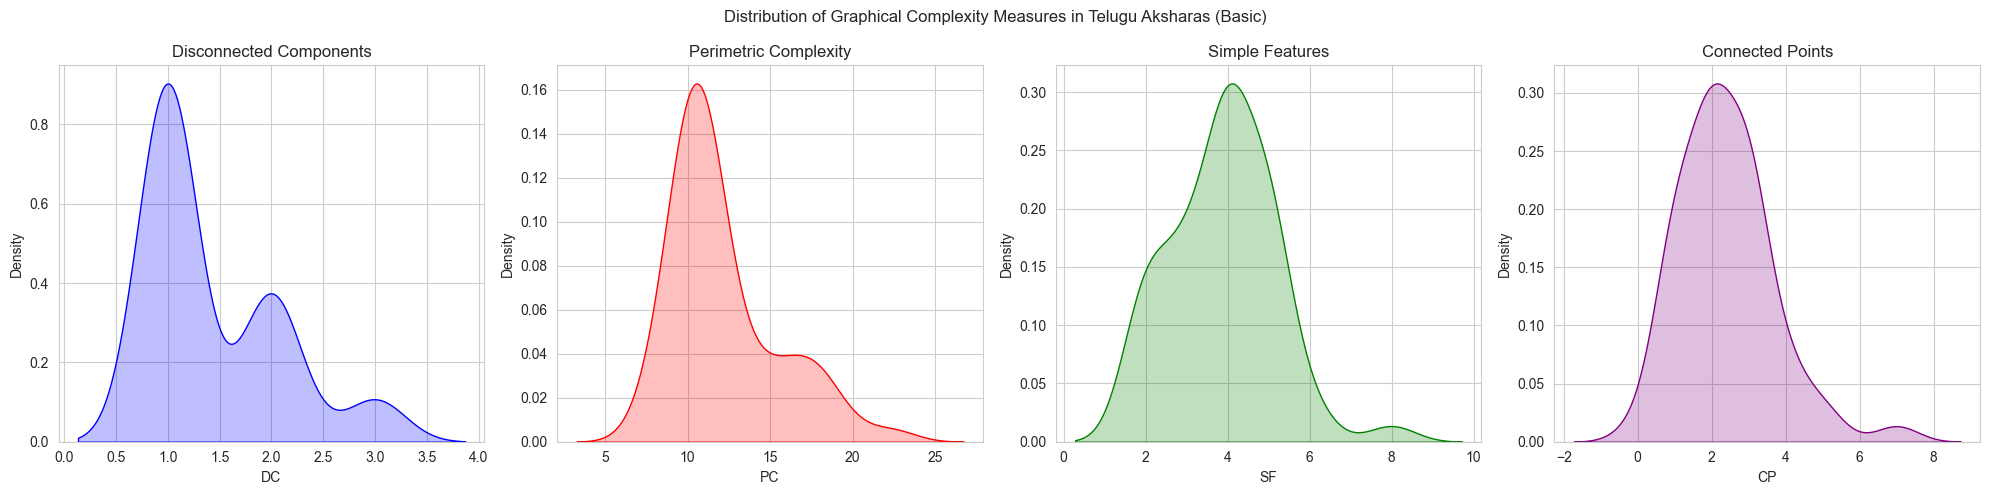

In [32]:
# plot all distributions as KDE

sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.kdeplot(df['dc'], ax=ax[0], color='blue', fill=True)
ax[0].set_title('Disconnected Components')
ax[0].set_xlabel('DC')

sns.kdeplot(df['pc'], ax=ax[1], color='red', fill=True)
ax[1].set_title('Perimetric Complexity')
ax[1].set_xlabel('PC')

sns.kdeplot(df['sf'], ax=ax[2], color='green', fill=True)
ax[2].set_title('Simple Features')
ax[2].set_xlabel('SF')

sns.kdeplot(df['cp'], ax=ax[3], color='purple', fill=True)
ax[3].set_title('Connected Points')
ax[3].set_xlabel('CP')

plt.suptitle('Distribution of Graphical Complexity Measures in Telugu Aksharas (Basic)')
plt.tight_layout()
plt.show()


In [34]:
# print statistics

df.describe()

,dc,pc,sf,cp
count,52.000000,52.000000,52.000000,52.000000
mean,1.423077,12.128649,3.884615,2.384615
std,0.636971,3.213151,1.262643,1.270384
min,1.000000,7.661644,2.000000,0.000000
25%,1.000000,10.122320,3.000000,1.750000
50%,1.000000,10.999819,4.000000,2.000000
75%,2.000000,13.236157,5.000000,3.000000
max,3.000000,22.326336,8.000000,7.000000
